# Introduzione
Questo progetto mira a condurre un’analisi del dataset Ionosphere, originariamente raccolto dal gruppo di fisica spaziale della Johns Hopkins University (Sigillito et al., 1989). Il dataset contiene dati radar ad alta frequenza raccolti da un sistema di antenne situato a Goose Bay, Labrador. L’obiettivo principale è applicare tecniche di data mining per classificare i ritorni radar come buoni (Good, g) o cattivi (Bad, b), determinando se il segnale mostra evidenza di una struttura nella ionosfera o se passa attraverso di essa senza riflessione.

Ogni istanza è descritta da 34 variabili numeriche continue, che rappresentano una mappa dettagliata della funzione di autocorrelazione del segnale radar. Nello specifico, le feature corrispondono alle 17 coppie di componenti (reale e immaginaria) calcolate per ciascun ritardo dell'impulso. L'analisi di queste variabili permette di distinguere una struttura ionosferica, caratterizzata da uno spostamento di fase coerente, dal semplice rumore di fondo o da una diffusione disordinata del segnale.

In [34]:
# --- Import librerie necessarie ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates

# --- Per il Caricamento Dati  ---
from sklearn.datasets import fetch_openml

# --- Per Preprocessing e Valutazione ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# --- Per i Modelli di Classificazione ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import math
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, mutual_info_classif
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import random

In [35]:
# Costanti globali per garantire riproducibilità e configurabilità
RANDOM_STATE = 42  # Per riproducibilità dei risultati
TEST_SIZE = 0.2    # 20% dei dati per il test set
CV_FOLDS = 5       # 5-fold cross validation

In [36]:
# Seme per il generatore di Python
random.seed(RANDOM_STATE)

# Seme per NumPy (usato internamente da molte funzioni di sklearn)
np.random.seed(RANDOM_STATE)

In [37]:
# Caricamento e preparazione dataset Ionosphere
try:
    ionosphere = fetch_openml(name="ionosphere")
except Exception as e:
    print(f"Errore nel caricamento dati: {e}")
    
df = pd.DataFrame(ionosphere.data, columns=ionosphere.feature_names)
df["class"] = ionosphere.target

#Analisi preliminare
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()


--- Prime 5 righe del DataFrame Combinato ---
   a01  a02      a03      a04      a05      a06      a07      a08      a09  \
0    1    0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.00000   
1    1    0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.00000   
2    1    0  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062  0.88965   
3    1    0  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000  0.00000   
4    1    0  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255  0.77152   

       a10  ...      a26      a27      a28      a29      a30      a31  \
0  0.03760  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090  0.42267   
1 -0.04549  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593 -0.16626   
2  0.01198  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365  0.60436   
3  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099  0.25682   
4 -0.16399  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197 -0.05707   

       a32      a33      a34  class  
0 -0.54

Qui vengono mostrate le prime 5 istanze del dataset. Possiamo notare che le feature si chiamano con la sigla "aX" con X che va da 01 a 34. Esempio: la prima colonna e la seconda colonna (a01 e a02) rappresentano la parte reale e immaginaria della funzione di autocorrelazione con ritardo zero, ovvero la correlazione del segnale con se stesso senza alcuno spostamento temporale.

In [38]:
print(f"Shape iniziale: {df.shape}")

# --- Valori mancanti ---
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"Valori mancanti:\n{missing[missing > 0]}")
    df = df.dropna()
else:
    print("Nessun valore mancante")


# --- Feature a varianza zero/quasi-zero ---
# Rimuove feature con varianza < 0.01 che non portano informazione utile

X_temp = df.drop('class', axis=1)
var_selector = VarianceThreshold(threshold=0.00)
var_selector.fit(X_temp)

low_var_features = X_temp.columns[~var_selector.get_support()].tolist()
if low_var_features:
    print(f"Feature a bassa varianza rimosse: {low_var_features}")
    df = df.drop(columns=low_var_features)
else:
    print("Nessuna feature a bassa varianza")
    
# Aggiorna la lista delle feature dopo la rimozione
feature_column_names = df.drop(columns=['class']).columns.tolist()

Shape iniziale: (351, 35)
Nessun valore mancante
Feature a bassa varianza rimosse: ['a02']


Il dataset risulta completo e privo di valori mancanti. L'analisi della varianza ha portato alla rimozione della feature a02, poiché presenta un valore costante per tutte le osservazioni (varianza nulla). Questo è teoricamente corretto: a02 corrisponde alla parte immaginaria dell'autocorrelazione a ritardo zero, che per definizione matematica è sempre nulla. Essendo un dato che non cambia mai, non fornisce alcuna informazione utile al modello per la classificazione e può essere eliminato.

# INIZIO ANALISI DEL DATASET

Qui vengono mostrati i grafici per un'analisi esplorativa del dataset. Verranno mostrate le distribuzioni delle feature, la correlazione lineare tra esse e la distribuzione delle classi

### Grafico a torta

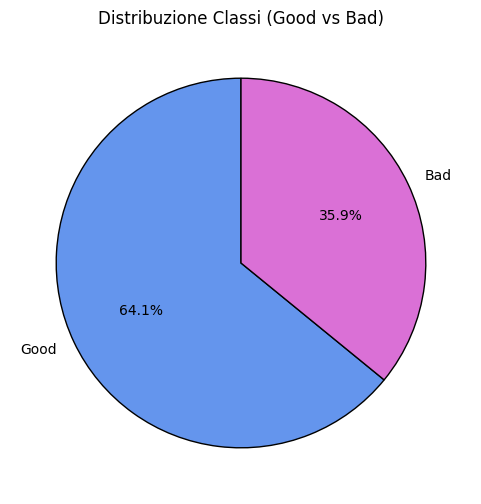

In [39]:
## VISUALIZZAZIONI (Grafico a Torta) ---

#Mappatura delle classi
class_map = {'b': 'Bad', 'g': 'Good'}
color_map_dict = {'Good': 'cornflowerblue', 'Bad': 'orchid'}

# Copia e crea la colonna etichettata
df_plot = df.copy()
df_plot['Radar_Label'] = df['class'].map(class_map)
df_plot = df_plot.drop(columns=['class'])

#Grafico a Torta (Distribuzione Classi)
plt.figure(figsize=(6, 6))

# Conta le classi e ordina
counts = df_plot['Radar_Label'].value_counts()

# Applica la color map in base all’ordine delle etichette
colors = [color_map_dict[label] for label in counts.index]

# Crea il grafico
counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (Good vs Bad)')
plt.ylabel('')
plt.show()


Il grafico evidenzia uno sbilanciamento moderato nel dataset: la classe Good è predominante, rappresentando il 64.1% dei campioni, rispetto al 35.9% della classe Bad.

Sebbene non si tratti di uno squilibrio estremo, questa disparità potrebbe indurre il modello a favorire la classe maggioritaria. Per garantire una valutazione affidabile e imparziale, in fase di addestramento e validazione verranno adottate tecniche specifiche, come la stratificazione nella suddivisione dei dati (Stratified Split) e l'utilizzo di metriche più robuste dell'accuratezza (es. F1-Score o ROC-AUC) per monitorare le performance sulla classe minoritaria.

### Grafico coordinate parallele

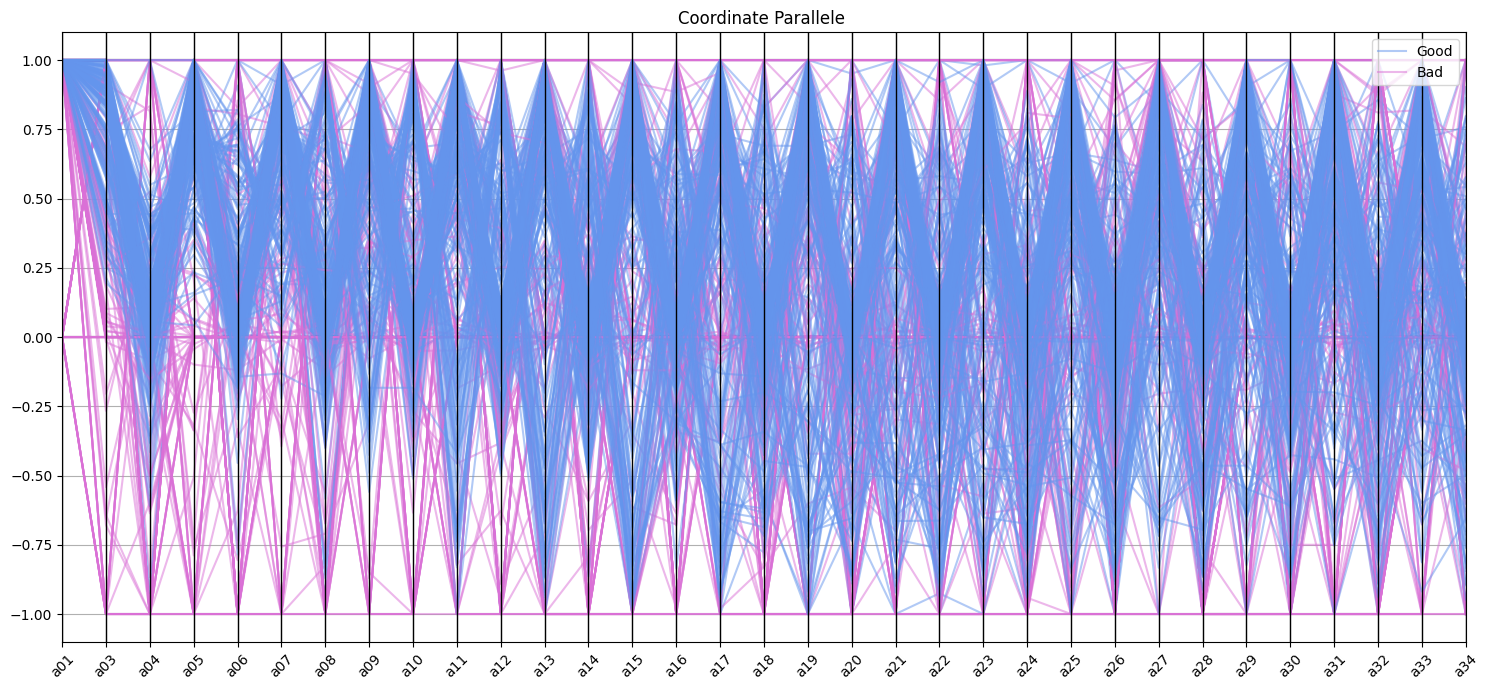

In [40]:
## VISUALIZZAZIONI (Coordinate Parallele) ---
plt.figure(figsize=(15, 7))

# Grafico delle coordinate parallele
parallel_coordinates(df_plot, 'Radar_Label', color=['cornflowerblue', 'orchid'], alpha=0.5)

plt.title('Coordinate Parallele ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Il grafico offre un riscontro visivo immediato sulla natura dei dati. Si nota chiaramente come la classe Good (in blu) tenda a raggrupparsi in fasci densi e ordinati, evidenziando la coerenza di fase tipica di un segnale strutturato riflesso dalla ionosfera. Al contrario, la classe Bad (in rosa) appare estremamente dispersa e irregolare lungo tutto l'intervallo dei valori, riflettendo il comportamento caotico che caratterizza il rumore di fondo o la diffusione incoerente.

### Distribuzione delle feature differenziate per classi

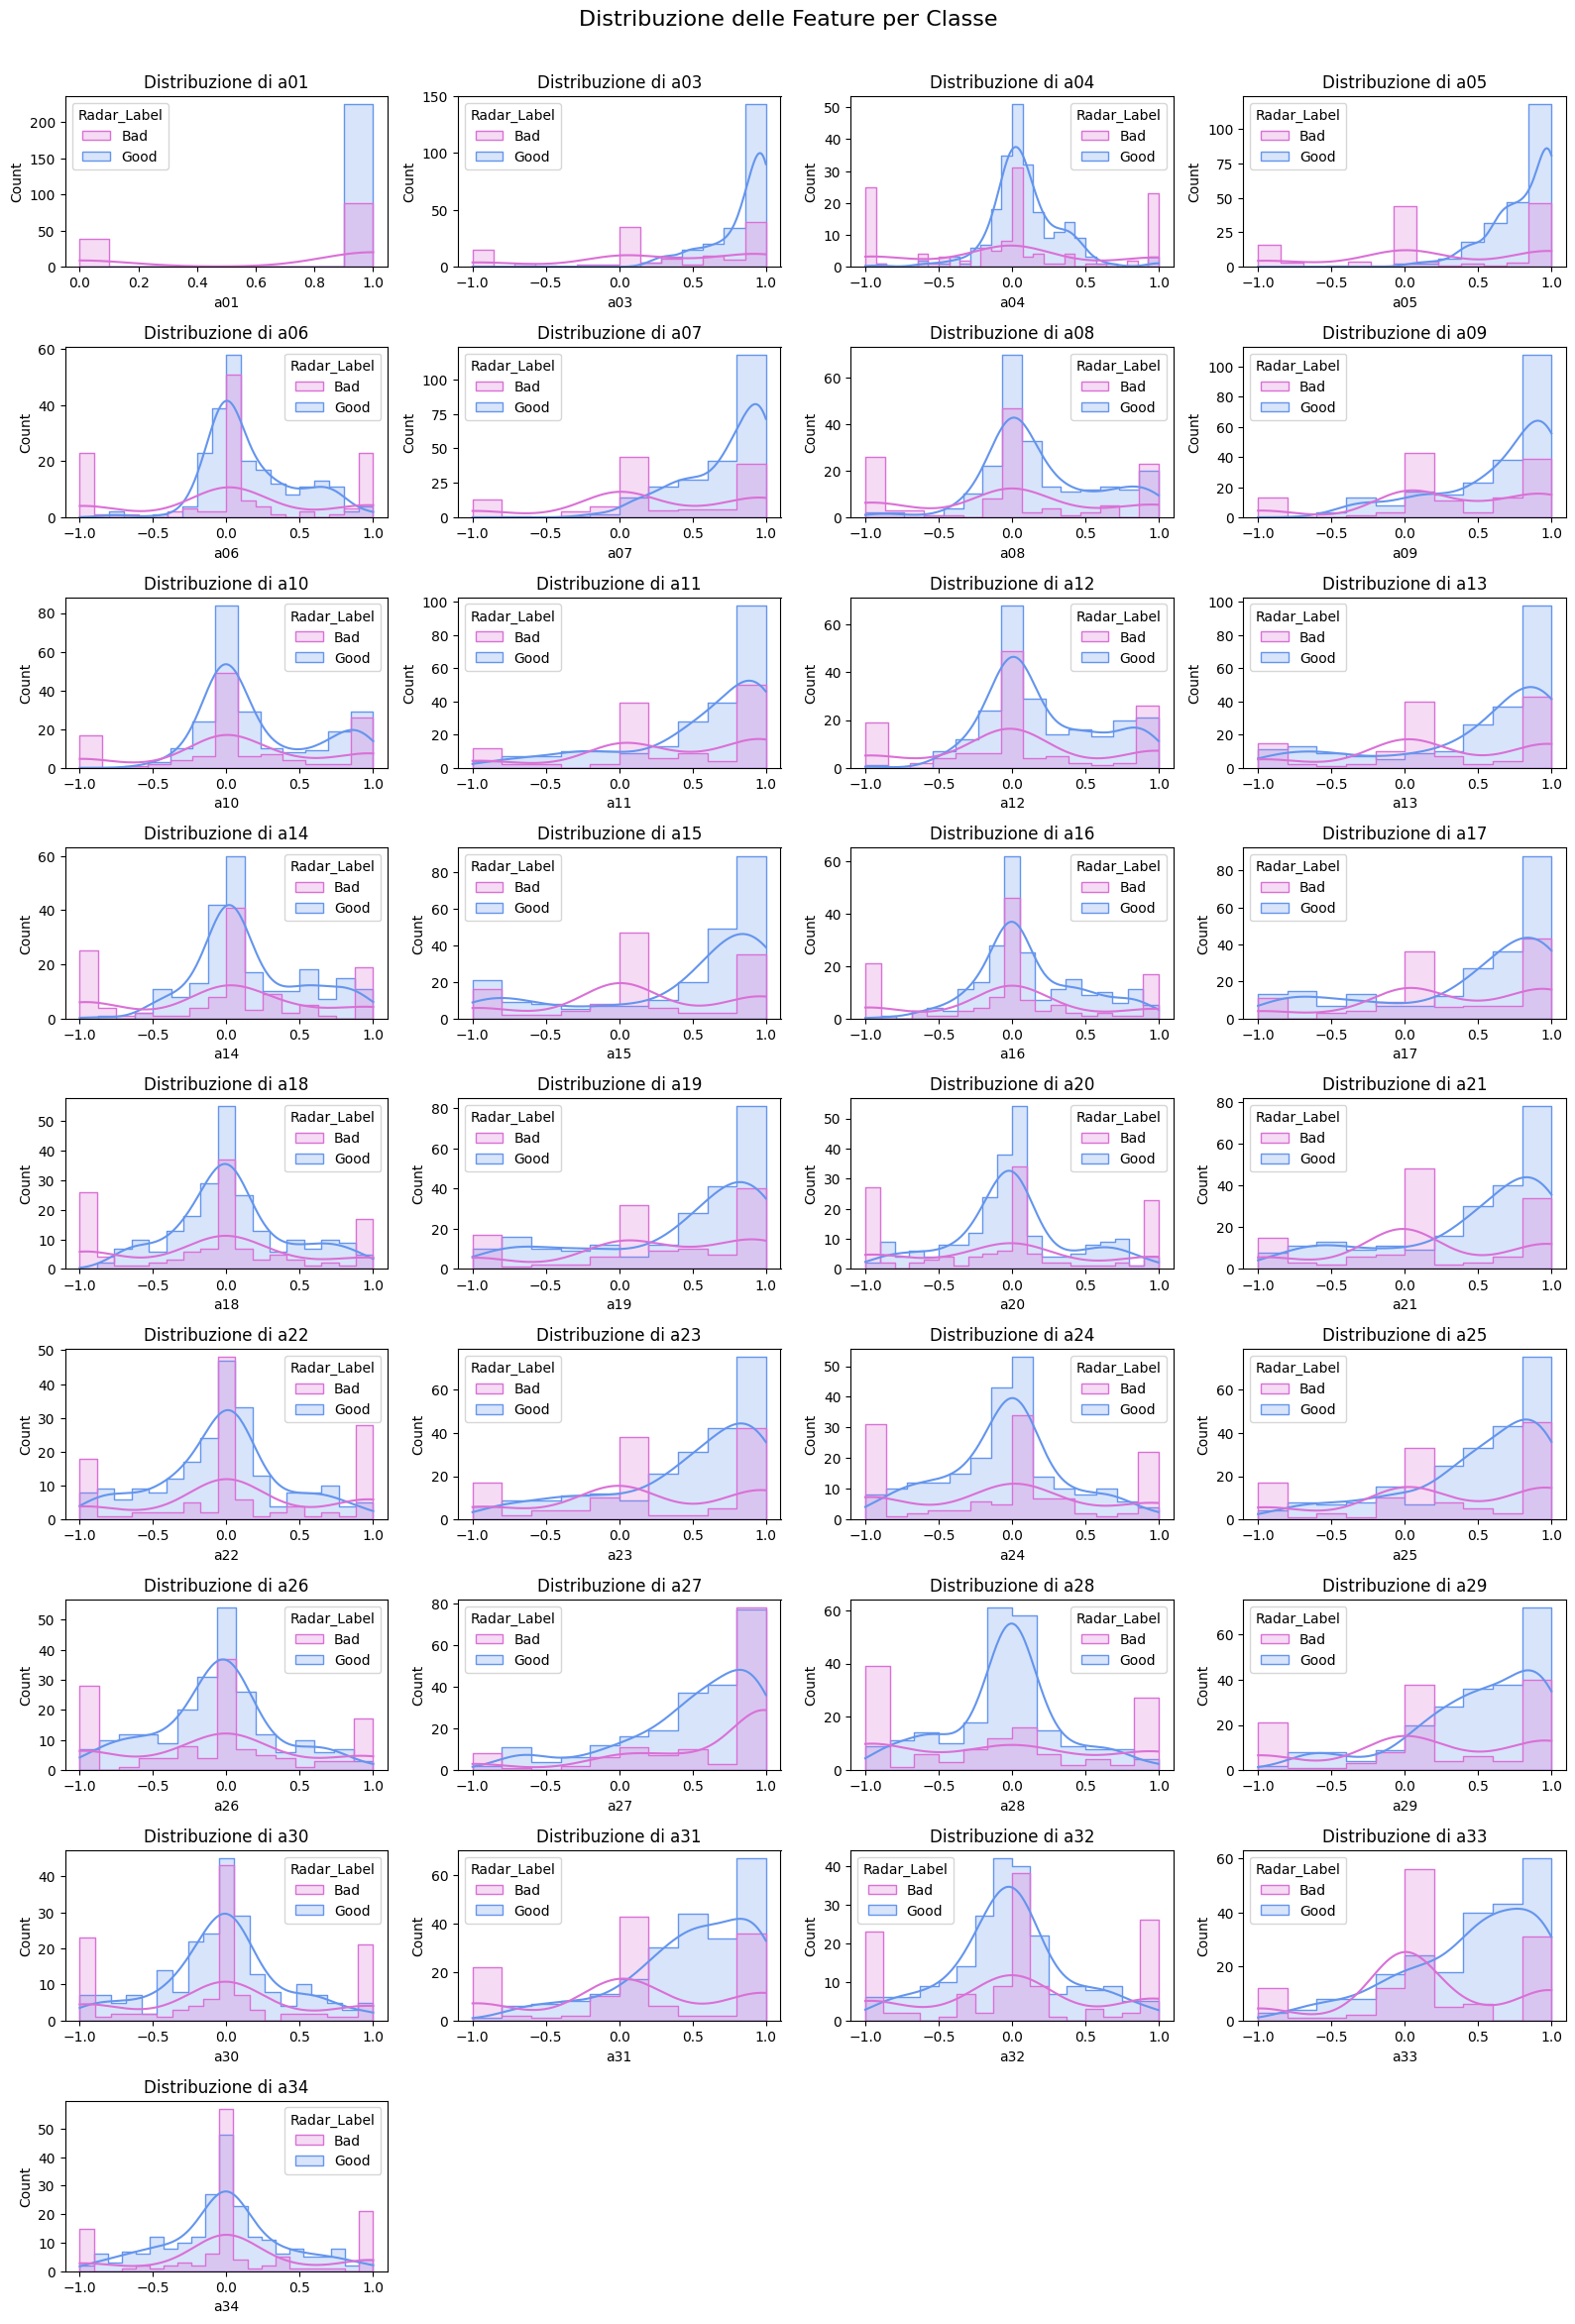

In [41]:
## --- Istogrammi Distribuzioni Feature ---
# Visualizza come le feature discriminano tra classi

plt.figure(figsize=(16, 25))
for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.histplot(
        df_plot,
        x=feature,
        hue='Radar_Label',
        kde=True,
        palette=color_map_dict,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Feature per Classe', y=1.02, fontsize=16)
plt.show()

L'analisi degli istogrammi rivela differenze strutturali significative tra le due categorie. La classe Good (in blu) tende a mostrare distribuzioni compatte e spesso unimodali (picchi ben definiti), indicando che i segnali validi condividono pattern statistici ricorrenti e regolari. Al contrario, la classe Bad (in rosa) presenta profili molto più appiattiti, uniformi o dispersi sull'intero intervallo dei valori, riflettendo la natura casuale e disordinata tipica del rumore.

### Box plot delle feature

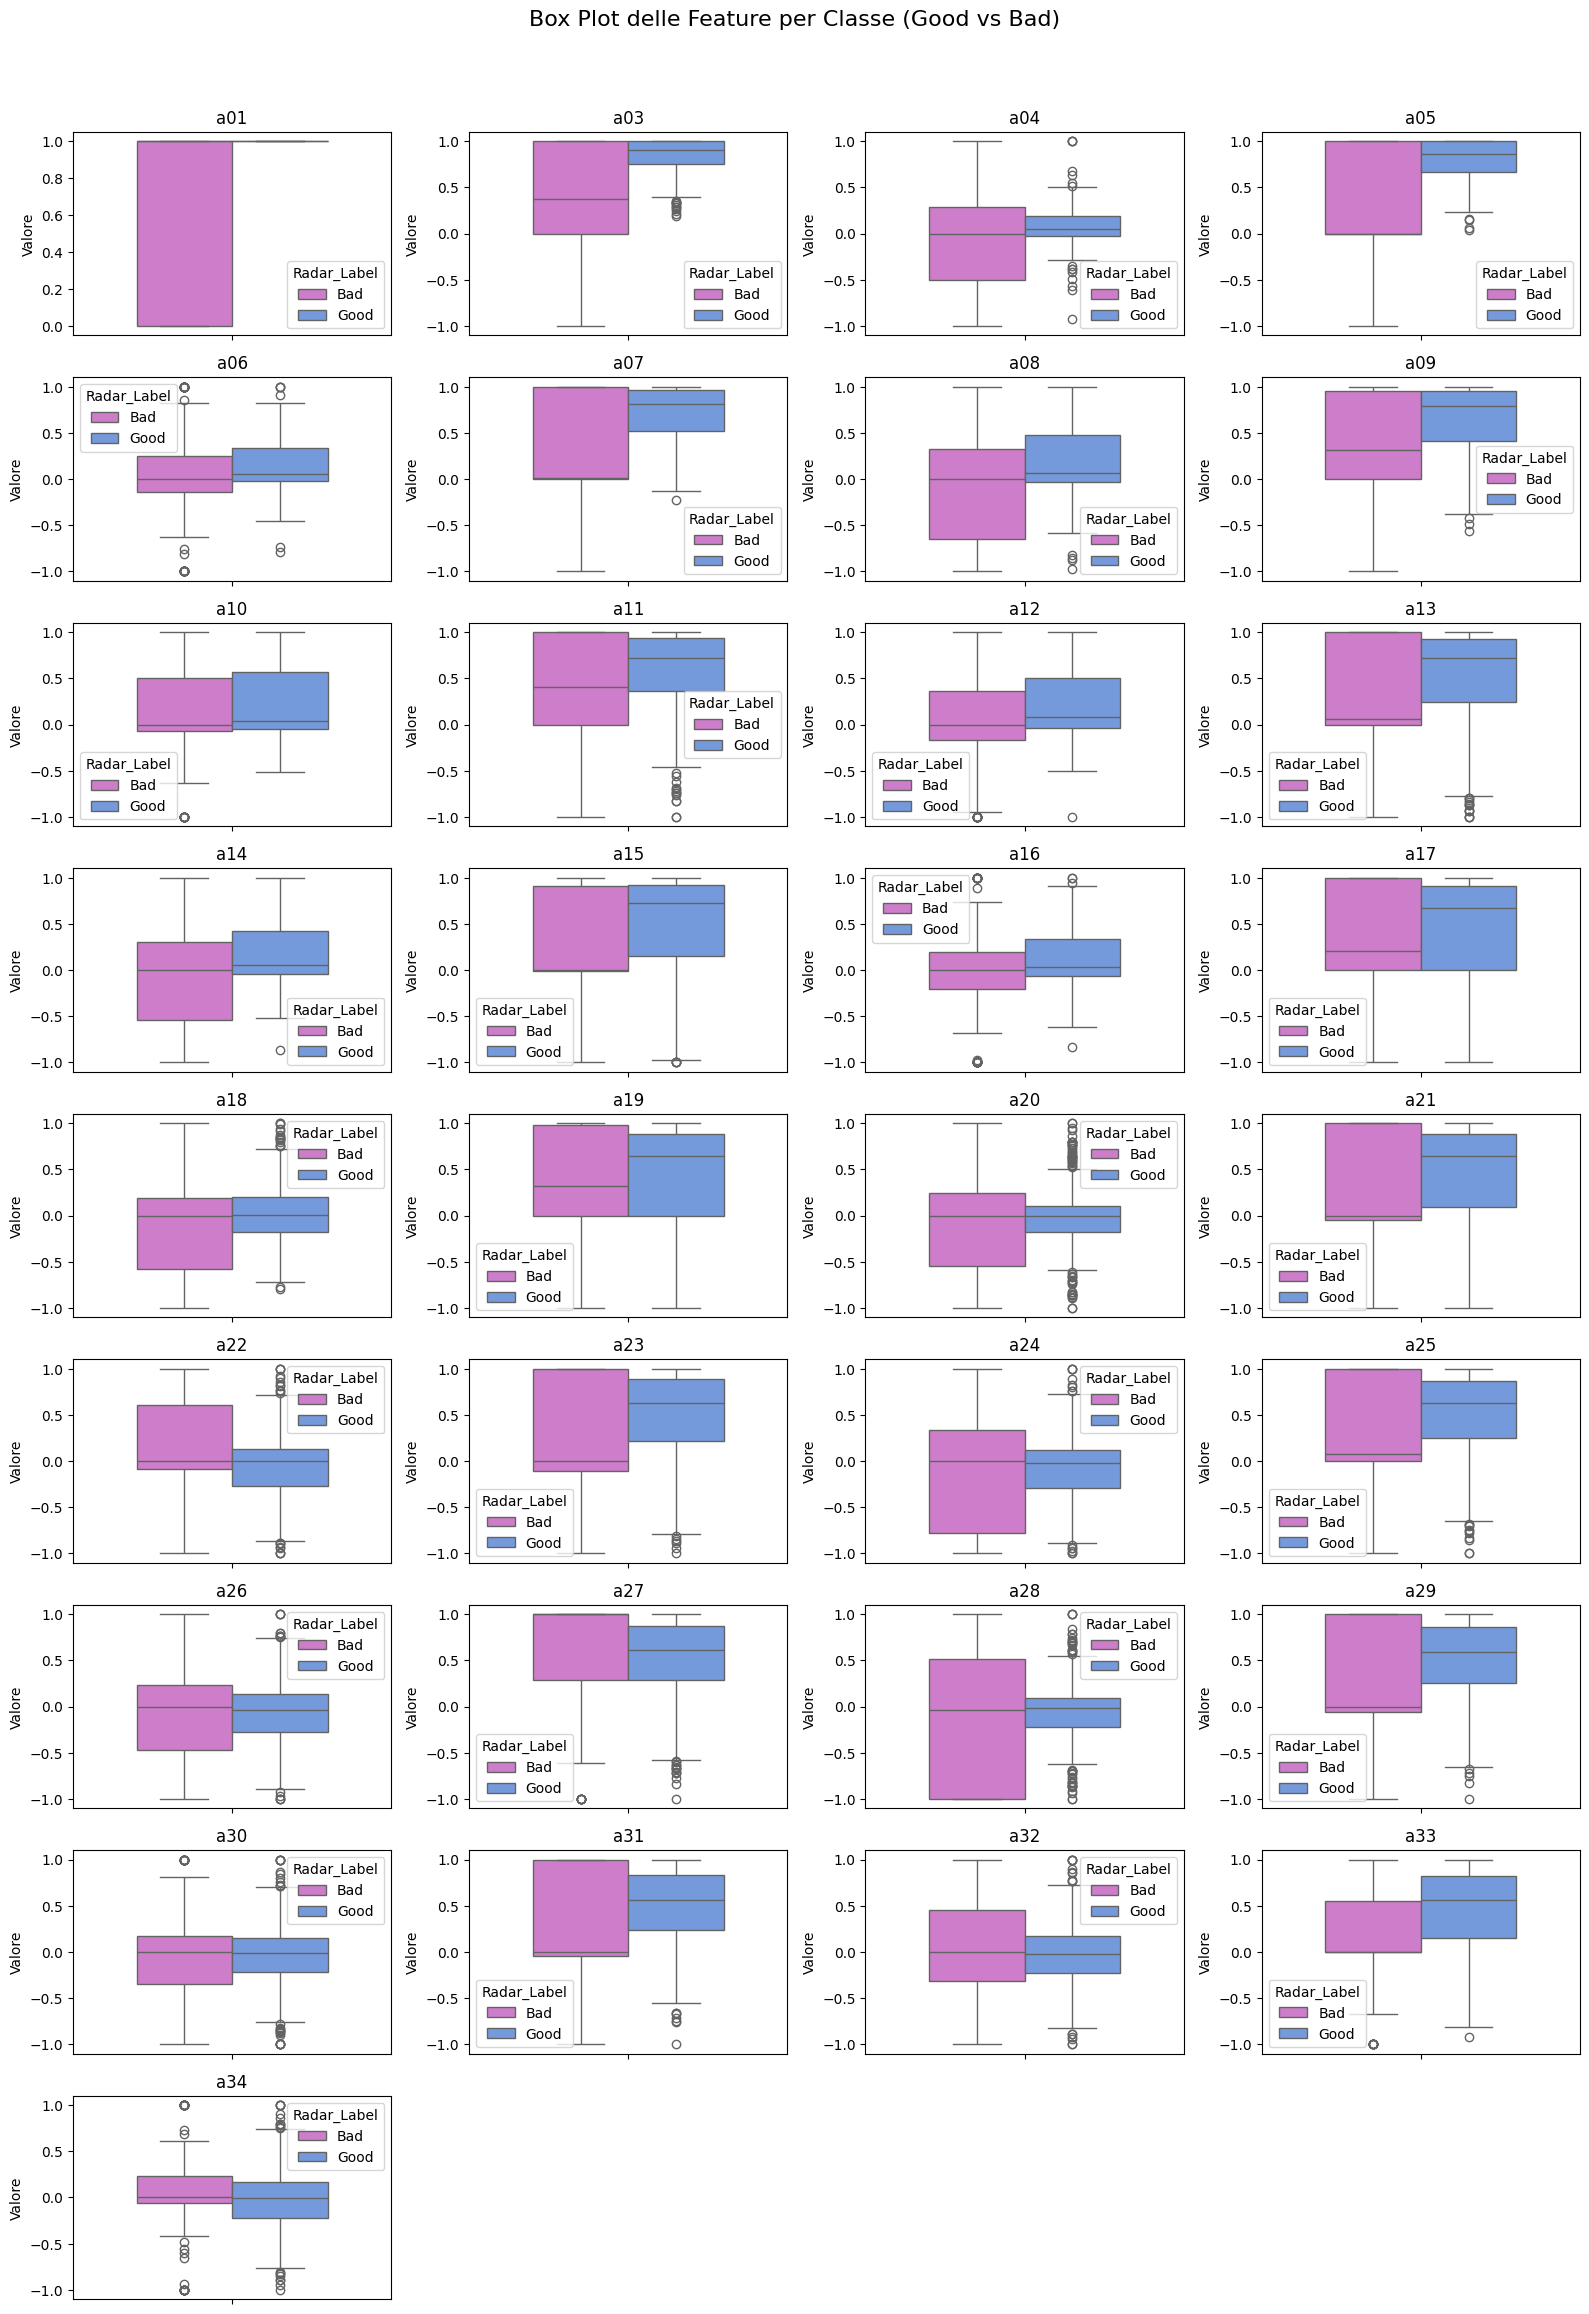

In [42]:
## --- Box Plots per Feature Selezionate ---
# Visualizzazione alternativa per vedere outlier e distribuzione

plt.figure(figsize=(16, 25))
for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.boxplot(
        df_plot,
        hue='Radar_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.ylabel('Valore')

plt.suptitle('Box Plot delle Feature per Classe (Good vs Bad)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

L'esame dei boxplot conferma visivamente la diversa natura fisica dei segnali. La classe Good (in blu) mostra distribuzioni generalmente compatte e schiacciate con mediana variabile nel range [0, 1], sintomo di una forte coerenza nel segnale riflesso. Al contrario, la classe Bad (in rosa) è caratterizzata da una variabilità molto più elevata e irregolare con mediana sempre vicina allo zero, che riflette la natura caotica e dispersa del rumore. È interessante notare la presenza di numerosi outlier nella classe Good, segno che anche i segnali validi possono occasionalmente presentare deviazioni significative dal pattern standard.

### Matrice di correlazione lineare tra le feature

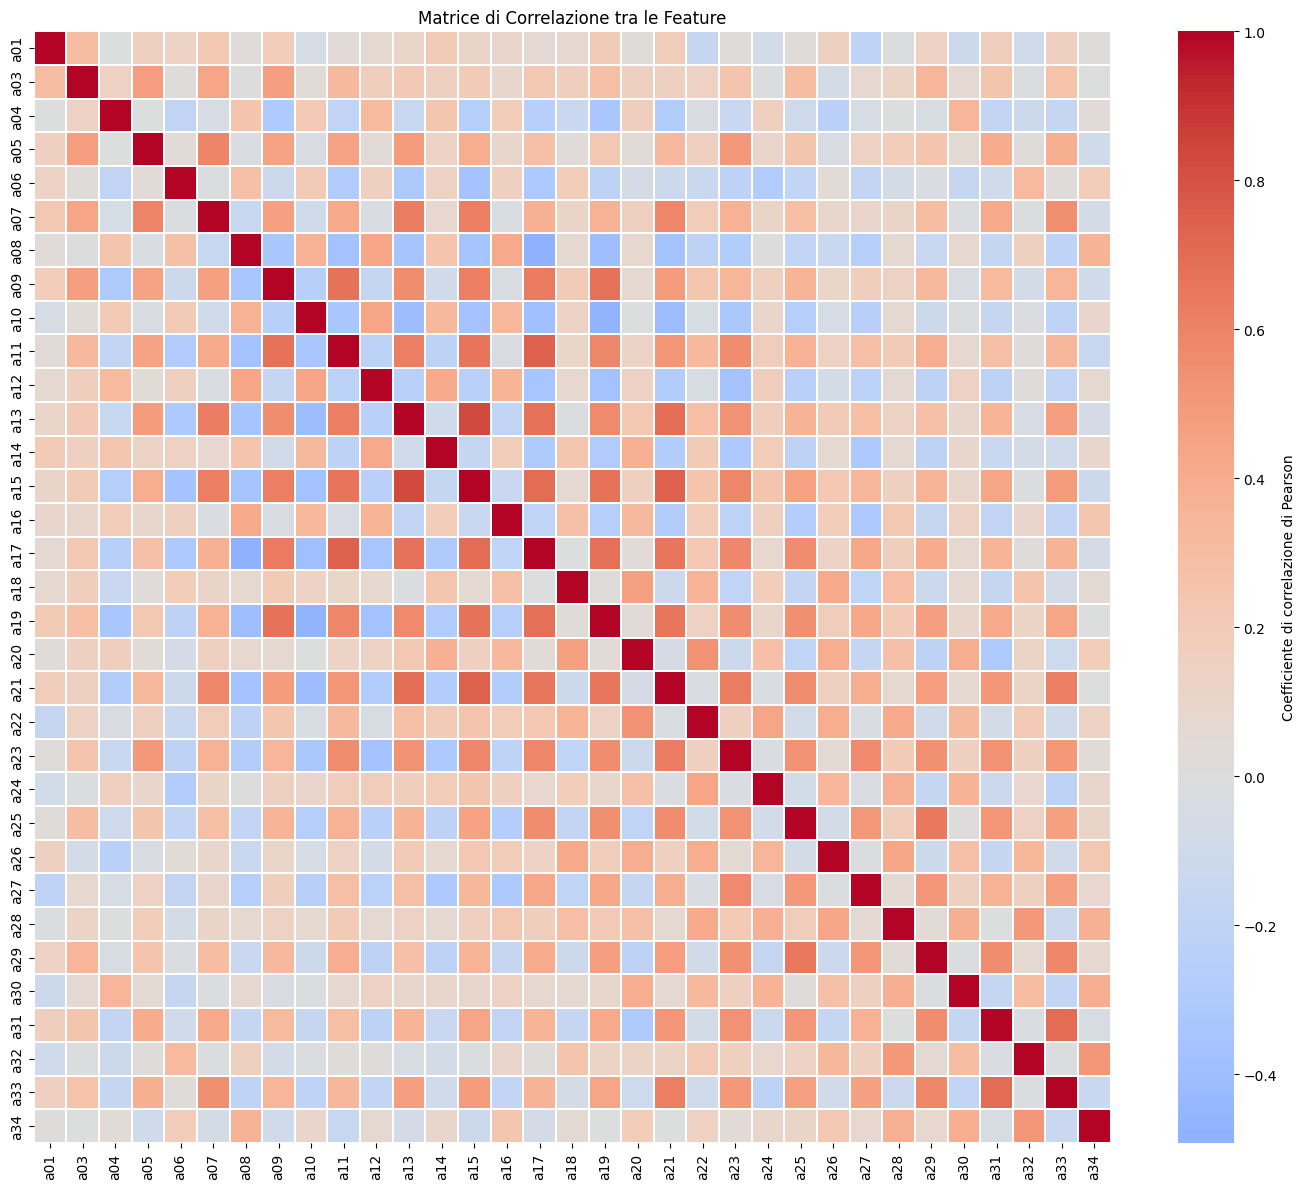

In [43]:
## --- VISUALIZZAZIONI ( Matrice di Correlazione) ---

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',        
    center=0,             
    annot=False,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)
plt.title('Matrice di Correlazione tra le Feature')
plt.tight_layout()
plt.show()

L'esame della matrice rivela una struttura di correlazione complessa. Non si osserva una ridondanza massiccia e generalizzata, bensì un pattern a scacchiera: le correlazioni più forti (in rosso) tendono a emergere tra feature attorno alla fascia centrale, dove l'interdipendenza si fa più marcata. Al contrario, la presenza di vaste aree neutre (in grigio/bianco) indica che molte coppie di variabili mantengono una significativa indipendenza lineare, suggerendo che i diversi ritardi temporali apportano spesso contributi informativi distinti e non semplicemente ripetitivi.

# Inizio classificazione: Test Iperparametri di base
Qui inizia la fase di machine learning dove verranno allenati diversi modelli mantenendo gli iperparametri ai loro valori di default. Gli unici iperparametri modificati sono il random_state, per la riproducibilità, e il class_weight/scale_pos_weight, per tenere conto dello sbilanciamento delle classi.

In [44]:
#Separa feature e target
X = df.drop('class', axis=1).values
y = df['class'].values

# Mapping esplicito: Good=0, Bad=1
class_mapping = {'g': 0, 'b': 1}
y = df['class'].map(class_mapping).values

# Divisione in Train/Test 
# Split Train/Test con stratificazione per mantenere proporzioni
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")
print(f"Distribuzione Classi in y_train: {np.bincount(y_train)}")
print(f"Distribuzione Classi in y_test: {np.bincount(y_test)}")


Dati di Addestramento (X_train): (280, 33)
Target di Addestramento (y_train): (280,)
Dati di Test (X_test): (71, 33)
Target di Test (y_test): (71,)
Distribuzione Classi in y_train: [179 101]
Distribuzione Classi in y_test: [46 25]


Il dataset è stato suddiviso in set di addestramento (280 campioni) e di test (71 campioni). Un passaggio cruciale è stato l'utilizzo del parametro stratify=y: questa tecnica garantisce che la proporzione originale tra le classi (Good/Bad) venga preservata identica in entrambi i sottoinsiemi.

Ciò è fondamentale per evitare di avere un set che contiene troppe istanze con la stessa classe, assicurando che il modello venga valutato su una distribuzione rappresentativa dei dati reali. L'output conferma inoltre la presenza di 33 feature, coerente con la rimozione precedente della variabile a varianza nulla.

In [45]:
# Converti in array NumPy
X_train = np.array(X_train)
X_test = np.array(X_test)

In [46]:
def evaluate_model(model, X_test, y_test, average='binary', target_label = 1, verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    
    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [47]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced' 
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM": SVC( 
        random_state=RANDOM_STATE,
        class_weight='balanced'  
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE,
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'  
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE,  
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()   
    )
}

Viene inizializzato un set eterogeneo di classificatori per confrontare approcci diversi, spaziando da metodi geometrici (SVM, KNN) a modelli basati su alberi (Decision Tree, Random Forest, XGBoost) e reti neurali (MLP).

Un aspetto cruciale in questa configurazione è la gestione esplicita dello sbilanciamento delle classi osservato in precedenza. Per i modelli che lo supportano (SVM, Decision Tree, Random Forest), è stato attivato il parametro class_weight='balanced', che adatta automaticamente i pesi inversamente alla frequenza delle classi. Per XGBoost, è stato calcolato un peso specifico (scale_pos_weight) basato sul rapporto tra le istanze, garantendo che il modello non trascuri la classe minoritaria durante l'addestramento.

In [48]:
AVERAGE_TYPE = 'binary' 
TARGET_LABEL = 1

strat_cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")

# --- CICLO DI TRAINING E VALIDAZIONE ---
for name, model in models.items():
    print(f"Valutazione Modello: {name}")
   
    cv_scores = cross_val_score(model, X_train, y_train, cv=strat_cv, scoring='f1')
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f">> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    model.fit(X_train, y_train)
    
    metrics = evaluate_model(model, X_test, y_test, AVERAGE_TYPE, TARGET_LABEL ,True)
    
    metrics["Model"] = name
    results.append(metrics)
    
    cm = confusion_matrix(y_test, model.predict(X_test), labels=[0, 1])
    conf_matrices[name] = cm
    
    gen_error = cv_mean - metrics["F1"]
    print(f">> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")
    
    print("   ------------------------------------------------")

print("\nProcesso completato.")

Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
>> Stratified CV F1: 0.8140 (+/- 0.0520)
Accuracy:  0.915
Precision: 0.852
Recall:    0.92
F1-score:  0.885
>> Generalization Error (CV F1 - Test F1): -0.0710
   ------------------------------------------------
Valutazione Modello: KNN
>> Stratified CV F1: 0.7243 (+/- 0.0895)
Accuracy:  0.845
Precision: 1.0
Recall:    0.56
F1-score:  0.718
>> Generalization Error (CV F1 - Test F1): 0.0063
   ------------------------------------------------
Valutazione Modello: SVM
>> Stratified CV F1: 0.9164 (+/- 0.0461)
Accuracy:  0.944
Precision: 0.957
Recall:    0.88
F1-score:  0.917
>> Generalization Error (CV F1 - Test F1): -0.0006
   ------------------------------------------------
Valutazione Modello: MLP


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py

>> Stratified CV F1: 0.8751 (+/- 0.0522)
Accuracy:  0.93
Precision: 1.0
Recall:    0.8
F1-score:  0.889
>> Generalization Error (CV F1 - Test F1): -0.0139
   ------------------------------------------------
Valutazione Modello: Random Forest
>> Stratified CV F1: 0.9152 (+/- 0.0347)
Accuracy:  0.958
Precision: 1.0
Recall:    0.88
F1-score:  0.936
>> Generalization Error (CV F1 - Test F1): -0.0208
   ------------------------------------------------
Valutazione Modello: AdaBoost
>> Stratified CV F1: 0.8474 (+/- 0.0420)
Accuracy:  0.944
Precision: 1.0
Recall:    0.84
F1-score:  0.913
>> Generalization Error (CV F1 - Test F1): -0.0656
   ------------------------------------------------
Valutazione Modello: XGBoost
>> Stratified CV F1: 0.8557 (+/- 0.0849)
Accuracy:  0.958
Precision: 1.0
Recall:    0.88
F1-score:  0.936
>> Generalization Error (CV F1 - Test F1): -0.0803
   ------------------------------------------------

Processo completato.


L'analisi evidenzia un testa a testa tra Random Forest e XGBoost, che ottengono risultati identici sul Test Set (Accuracy 95.8%, F1 0.936). Tuttavia, osservando la deviazione standard della Cross-Validation, emerge il migliore modello.

Mentre il Random Forest mantiene una variabilità contenuta (+/- 0.0347), XGBoost mostra una deviazione standard molto elevata (+/- 0.0849). Questo indica una significativa instabilità: le performance di XGBoost oscillano pesantemente a seconda di come vengono mescolati i dati di training. Al contrario, il Random Forest si dimostra molto più robusto e consistente attraverso i diversi fold.

Inoltre, il fatto che tutti i modelli abbiano una Precision pari a 1.0 indica zero falsi allarmi (nessun segnale Good viene erroneamente scambiato per Bad). La sfida si gioca tutta sulla Recall (capacità di intercettare i segnali bad), dove Random Forest e XGBoost eccellono (0.88) rispetto agli altri. Considerando sia la potenza predittiva che la stabilità, il Random Forest risulta il modello complessivamente più affidabile.

In [49]:
df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Precision","Recall","F1"]
).set_index("Model")

# Mostra risultati ordinati per F1 score
df_results.sort_values("F1", ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
Random Forest,0.958,1.000,0.88,0.936
XGBoost,0.958,1.000,0.88,0.936
SVM,0.944,0.957,0.88,0.917
AdaBoost,0.944,1.000,0.84,0.913
MLP,0.930,1.000,0.80,0.889
Decision Tree,0.915,0.852,0.92,0.885
KNN,0.845,1.000,0.56,0.718


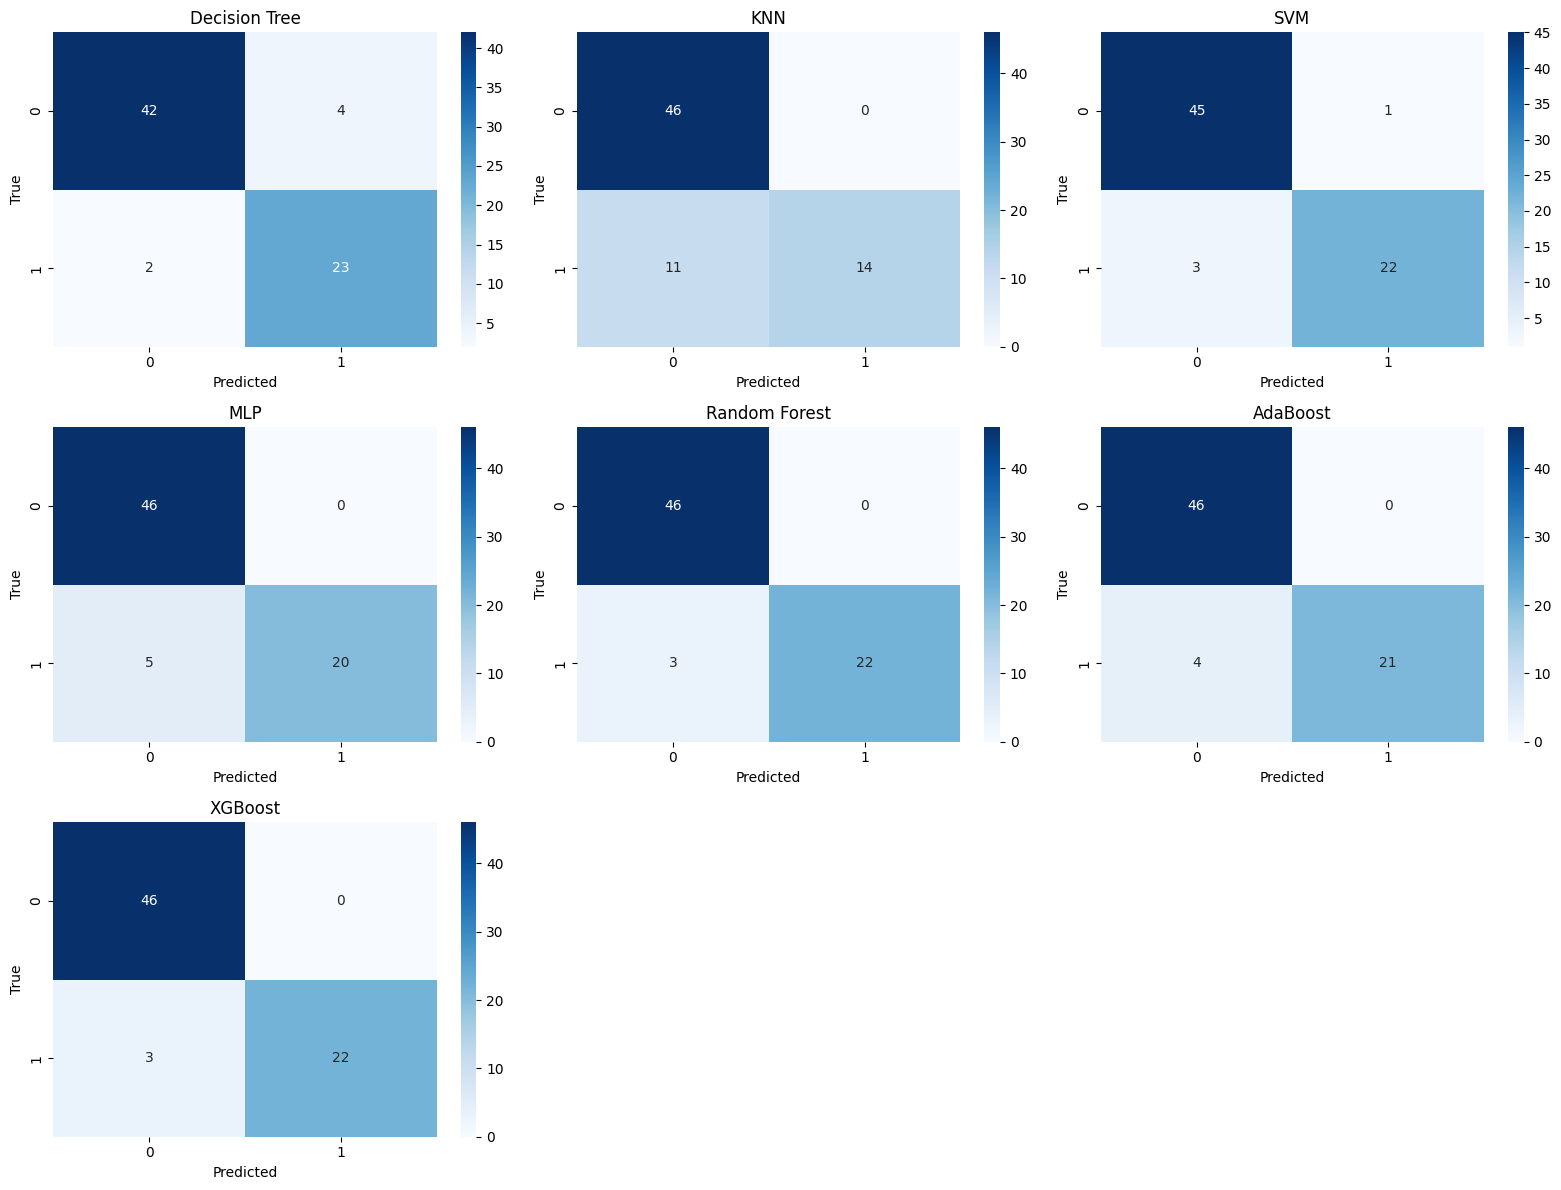

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# nascondi subplot vuoti
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Considerando la classe Bad come positiva (l'evento critico da rilevare), le matrici evidenziano un comportamento estremamente robusto e conservativo. Il dato più rassicurante è l'assenza totale di Falsi Positivi nei modelli migliori (Random Forest, XGBoost, AdaBoost, MLP): il sistema non genera mai falsi allarmi, classificando correttamente il 100% dei segnali buoni (Veri Negativi).

La competizione si gioca quindi interamente sulla Recall, ovvero la capacità di non lasciarsi sfuggire i segnali bad. Mentre classificatori come il KNN falliscono nel riconoscere quasi la metà delle minacce, Random Forest e XGBoost offrono le prestazioni migliori: riescono a intercettare 22 su 25 segnali critici, mancando (Falsi Negativi) solamente 3 istanze, il che li rende i candidati ideali per un sistema di filtraggio automatico.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


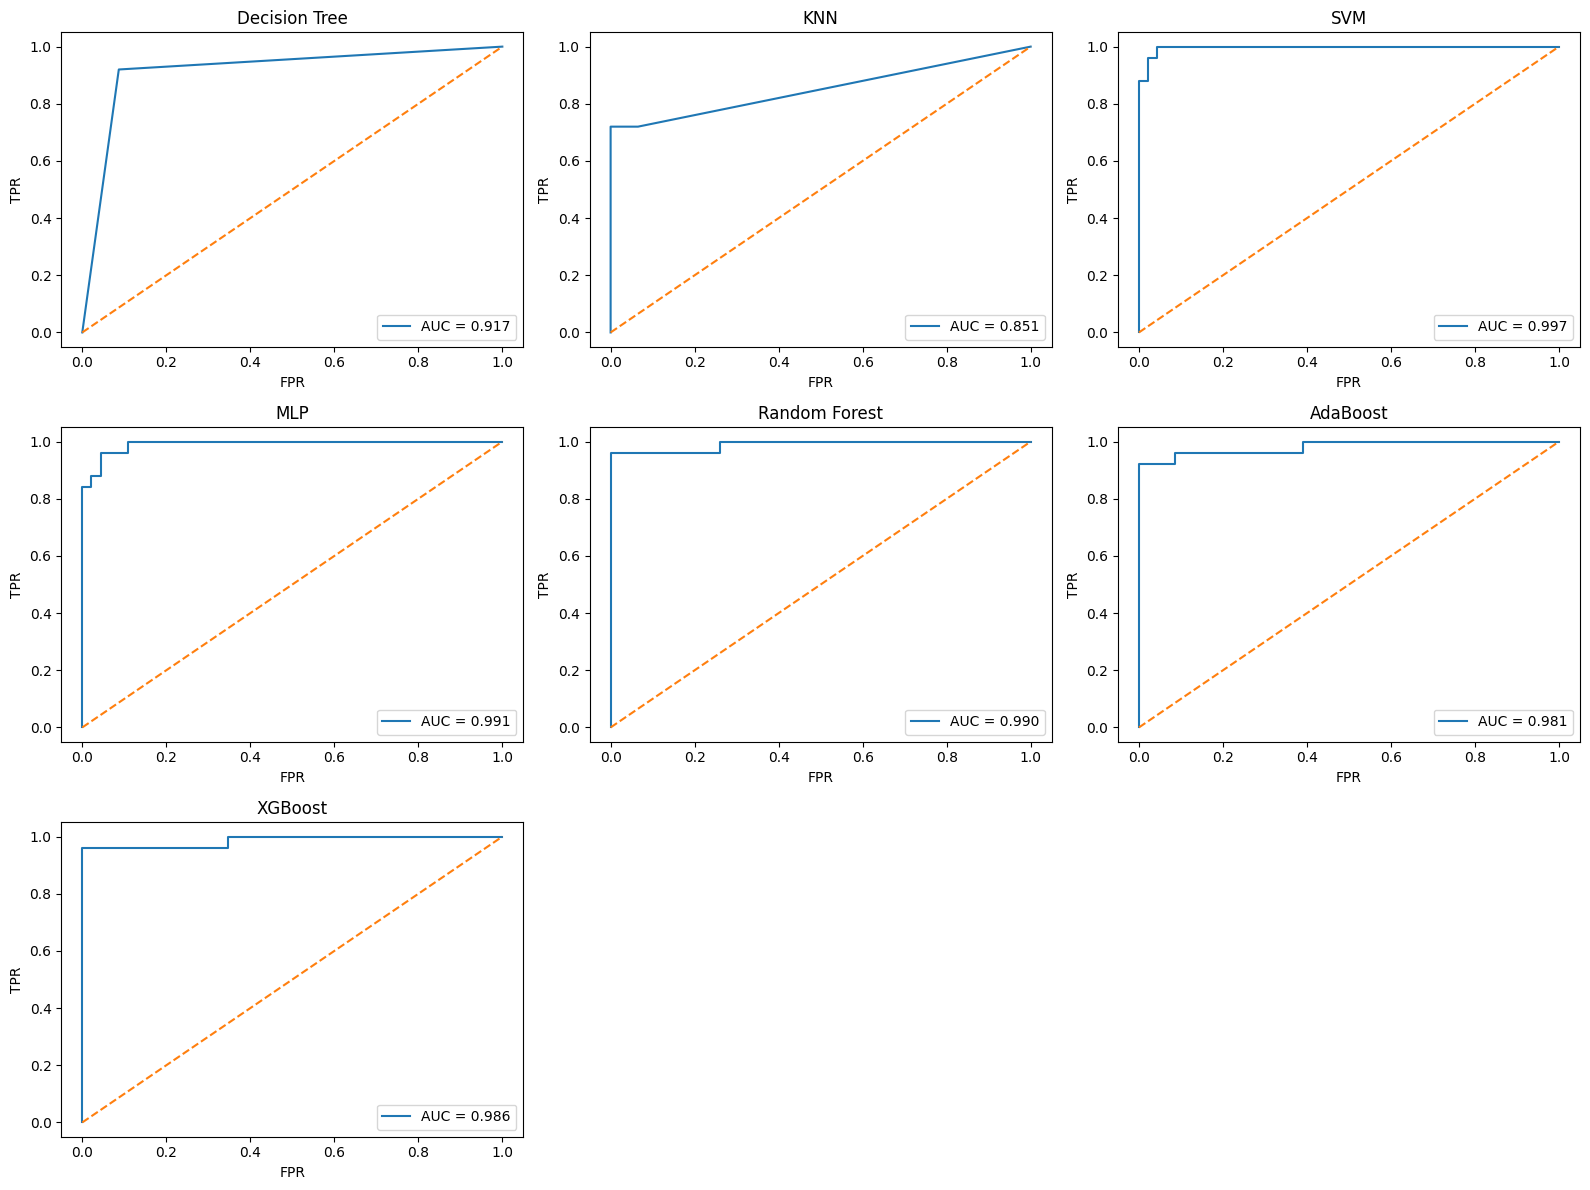

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")

# nascondi subplot vuoti se hai meno di 9 modelli
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Le curve ROC confermano l'eccellente capacità di discriminazione dei modelli: la maggior parte dei grafici si schiaccia verso l'angolo in alto a sinistra, indice di una netta separazione tra le classi.

Il dato più interessante è quello dell'SVM: sebbene nelle metriche standard sembrasse leggermente inferiore, qui registra l'AUC più alta in assoluto (0.997), superando persino Random Forest (0.990) e XGBoost (0.986). Questo suggerisce che l'SVM è statisticamente il modello più robusto nell'assegnare le probabilità e, con una calibrazione fine della soglia, potrebbe offrire le prestazioni migliori in assoluto. KNN e Decision Tree si confermano invece le opzioni meno performanti.

<Figure size 1400x700 with 0 Axes>

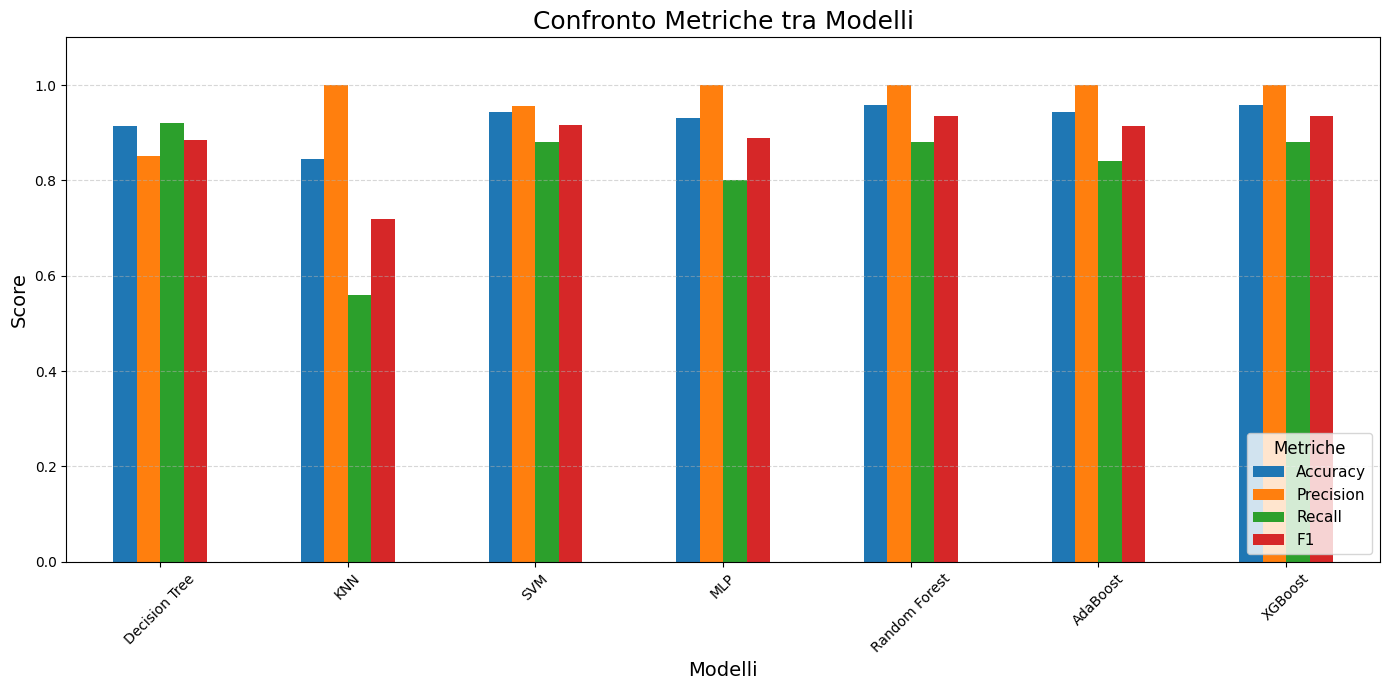

In [52]:
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

In [53]:
# Identifica il miglior modello basato su F1-score
best_model_name = df_results['F1'].idxmax()
best_f1_score = df_results['F1'].max()

print(f"\nMiglior modello: {best_model_name} con F1-score = {best_f1_score}")

# Estrai il modello migliore
best_model = models[best_model_name]
best_model.fit(X_train, y_train)


Miglior modello: Random Forest con F1-score = 0.936


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
def train_eval_2d_models(models, X_train_2d, X_test_2d, y_train, y_test, 
                         feature_names_2d, strat_cv, class_map=None, color_map_dict=None,
                         task_type='binary', pos_label=1, do_plot=True):
    """
        Addestra e valuta modelli su dati ridotti a 2 dimensioni.
        Visualizza anche i decision boundary per analisi visiva.
        
        Parameters:
        -----------
        models : dict - dizionario nome:modello
        X_train_2d, X_test_2d : dati 2D
        y_train, y_test : labels
        feature_names_2d : nomi delle 2 feature/componenti
        strat_cv :  stratified cross-validation
        do_plot : se True, visualizza il plot deidecision boundaries
    """
    results = {}
    
    # Setup per visualizzazione decision boundary
    if do_plot:
        n_models = len(models)
        n_cols = min(3, n_models)
        n_rows = math.ceil(n_models / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_rows > 1 or n_cols > 1 else [axes]
    
    for idx, (name, model) in enumerate(models.items()):
        # Clone del modello
        model_clone = clone(model)
        
        # Scelta dello scoring per CV 
        if task_type == 'binary':
            scoring = 'f1' if pos_label == 1 else make_scorer(f1_score, pos_label=pos_label)
        else:
            scoring = 'f1_weighted'
            
        # Cross-validation
        cv_scores = cross_val_score(model_clone, X_train_2d, y_train, cv=strat_cv, scoring=scoring)
        
        # Training
        model_clone.fit(X_train_2d, y_train)
        
        # Predizione
        y_pred = model_clone.predict(X_test_2d)
        
        # Calcolo metriche 
        if task_type == 'binary':
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, pos_label=pos_label)
            rec = recall_score(y_test, y_pred, pos_label=pos_label)
            f1 = f1_score(y_test, y_pred, pos_label=pos_label)
        else:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Salva risultati
        results[name] = {
            'model': model_clone,
            'cv_scores': cv_scores,
            'metrics': {
                'Accuracy': round(acc, 3),
                'Precision': round(prec, 3),
                'Recall': round(rec, 3),
                'F1': round(f1, 3)
            },
            'predictions': y_pred
        }
        
        # Plot decision boundary
        if do_plot:
            ax = axes[idx]

            mesh_cmap = ListedColormap([
                color_map_dict[class_map[0]],
                color_map_dict[class_map[1]]
            ])
            
            # Crea mesh
            h = 0.02 # Step size nel mesh
            x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
            y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            
            # Predizioni sul mesh
            Z = model_clone.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            
            # Plot contorno
            ax.contourf(xx, yy, Z, alpha=0.8, cmap=mesh_cmap)
            
            # Plot punti training
            train_colors = [color_map_dict[class_map[label]] for label in y_train]

            ax.scatter(
                X_train_2d[:, 0], X_train_2d[:, 1],
                c=train_colors,
                edgecolor='k', s=50, alpha=0.7
            )
            
            legend_elements = [
                Line2D(
                    [0], [0],
                    marker='o', color='w',
                    label=cls,
                    markerfacecolor=col,
                    markersize=8
                )
                for cls, col in color_map_dict.items()
            ]

            ax.legend(handles=legend_elements)
            
            ax.set_xlabel(feature_names_2d[0])
            ax.set_ylabel(feature_names_2d[1])
            ax.set_title(f'{name}\nTest F1={f1:.3f}')
            
            
    if do_plot:
        # Nascondi subplot vuoti
        for j in range(len(models), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Stampa risultati per il miglior modello
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['F1'])
    cv_scores = results[best_model_name]['cv_scores']
    print(f"\n=== Modello: {best_model_name} ===")
    print(f"   >> Stratified CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"   >> Metriche test: {results[best_model_name]['metrics']}")
    
    return results

# Inizio fase di riduzione dimensionalità
Per ridurre la complessità computazionale, verranno applicate tecniche di Feature Selection ed Extraction. Una volta identificate le due feature (o componenti) più significative per ciascun metodo, valuteremo la loro efficacia addestrando nuovamente il modello che ha mostrato le migliori performance sul dataset originale.

### 1. PCA - Principal Component Analysis

In [55]:
print("=== Analisi PCA ===")

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"\nVarianza per componente:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.3f} ({var*100:.1f}%)")

pca_feature_names = [f'PC{i+1}' for i in range(2)]

total_var = pca.explained_variance_ratio_.sum()
print(f"\nVarianza totale spiegata: {total_var:.3f} ({total_var*100:.1f}%)")
print(f"Informazione persa: {1-total_var:.3f} ({(1-total_var)*100:.1f}%)")

=== Analisi PCA ===

Varianza per componente:
  PC1: 0.314 (31.4%)
  PC2: 0.124 (12.4%)

Varianza totale spiegata: 0.437 (43.7%)
Informazione persa: 0.563 (56.3%)


I risultati della riduzione dimensionale offrono una conferma indiretta della complessità del dataset. Con soli due componenti principali, riusciamo a spiegare appena il 43.7% della varianza totale, il che significa che oltre la metà dell'informazione originale (56.3%) viene persa nella compressione.

Questo dato è perfettamente coerente con quanto osservato nella matrice di correlazione: poiché molte feature presentano un grado di indipendenza significativo (le "aree neutre" della heatmap), l'informazione è distribuita su molte dimensioni e non può essere facilmente schiacciata in un piano 2D senza perdere dettagli cruciali.

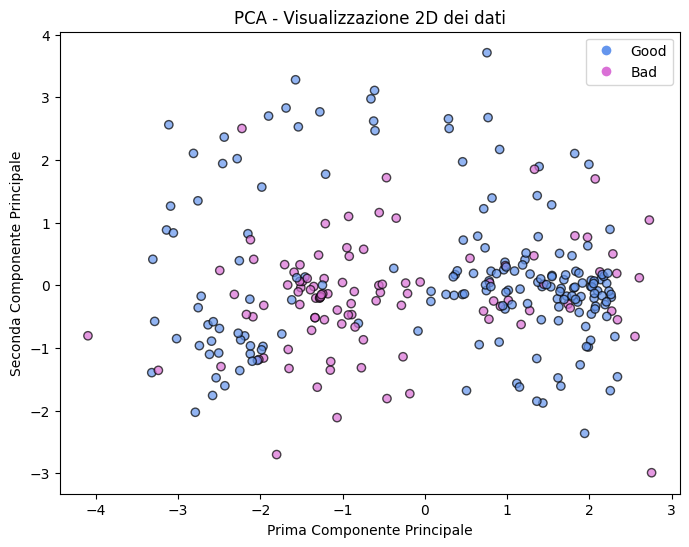

In [56]:
# Visualizza PCA

class_map = {0: 'Good', 1: 'Bad'}
colors = [color_map_dict[class_map[label]] for label in y_train]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors,
                    edgecolor='k', alpha=0.7)
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.title('PCA - Visualizzazione 2D dei dati')

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=cls, markerfacecolor=col, markersize=8)
    for cls, col in color_map_dict.items()
]

plt.legend(handles=legend_elements)

plt.show()

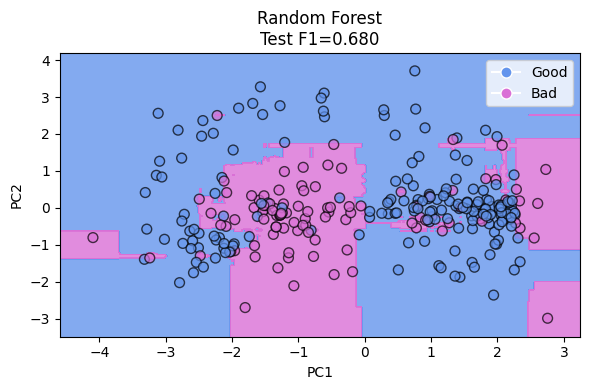


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.6914 (+/- 0.0282)
   >> Metriche test: {'Accuracy': 0.775, 'Precision': 0.68, 'Recall': 0.68, 'F1': 0.68}


In [57]:
# Valuta solo il miglior modello con PCA
models_pca = {best_model_name: models[best_model_name]}

results_pca = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_pca,
    X_test_2d=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=pca_feature_names,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

Il grafico visualizza chiaramente il costo della riduzione dimensionale: l'F1-Score crolla a 0.680, ben lontano dalle prestazioni eccellenti ottenute con il set completo di feature (0.936).

La causa è evidente nella forte sovrapposizione spaziale tra le classi: in 2D i punti Good e Bad appaiono mescolati. Questo dimostra che il modello non riesce più a separare i dati con sicurezza, confermando che l'informazione cruciale per la classificazione risiedeva nelle dimensioni sacrificate dalla PCA.

### 2. Feature Importance

In [58]:
importances = best_model.feature_importances_

# Ordina le feature per importanza
indices = np.argsort(importances)[::-1]
top_2_features = indices[:2]


# Seleziona top 2 features
X_train_fi = X_train[:, top_2_features]
X_test_fi = X_test[:, top_2_features]
feature_names_fi = [feature_column_names[i] for i in top_2_features]

print("Feature scelte:", feature_names_fi)

Feature scelte: ['a05', 'a27']


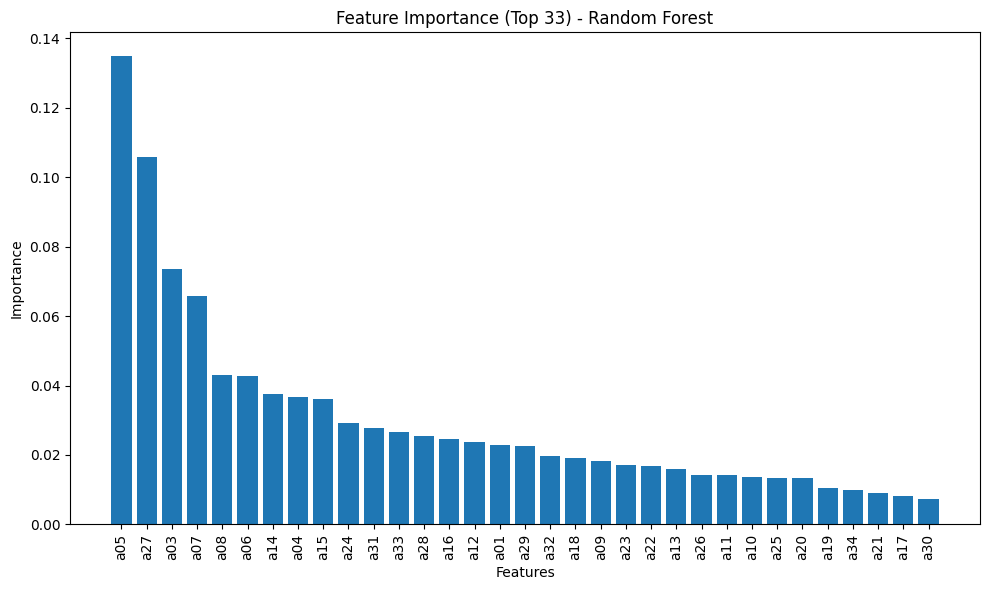

In [59]:
top_n = min(34, len(importances))
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices[:top_n]])
plt.xticks(range(top_n), [feature_column_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Feature Importance (Top {top_n}) - {best_model_name}')
plt.tight_layout()
plt.show()

Il grafico delinea una gerarchia netta: la variabile a05 domina su tutte, affermandosi come l'indicatore migliore per la classificazione. Tuttavia, l'informazione cruciale non è concentrata in un unico punto temporale: la presenza ai vertici di feature distanti tra loro (come la a03 e la a27) conferma che il modello deve analizzare l'intera evoluzione del segnale, dall'inizio alla fine, per decidere correttamente.

Infine, la lunga coda di barre decrescenti spiega perfettamente perché la PCA a due componenti ha fallito: sebbene poche feature siano molto forti, il modello raggiunge l'eccellenza solo sommando i piccoli contributi informativi di tutte le altre variabili, che non possono essere tagliate via senza perdere precisione.

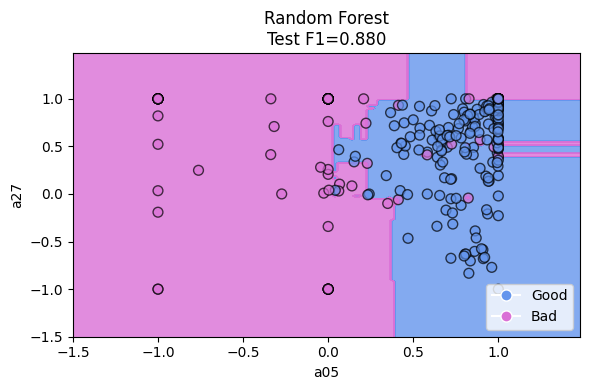


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.8592 (+/- 0.0374)
   >> Metriche test: {'Accuracy': 0.915, 'Precision': 0.88, 'Recall': 0.88, 'F1': 0.88}


In [60]:
results_fi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_fi,
    X_test_2d=X_test_fi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_fi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

L'utilizzo delle due sole variabili più importanti (a05 e a27) porta l'F1-Score a 0.880. Pur eliminando 31 feature, le prestazioni calano solo leggermente rispetto al valore originale di 0.936.

Questo risultato è nettamente superiore a quello della PCA (ferma a 0.680) e il grafico ne mostra il motivo: la variabile a05 offre una separazione naturale dei dati molto efficace (visibile nella soglia verticale attorno a 0.4). In sintesi, due feature reali e ben selezionate contengono molta informazione utile, permettendo al modello di avvicinarsi alle sue prestazioni massime con una complessità minima.

### 3. RFE - Recursive Feature Elimination

In [61]:
# RFE con il miglior modello
rfe = RFE(clone(best_model), n_features_to_select=2)
rfe.fit(X_train, y_train)

# Feature selezionate
rfe_selected_features = np.where(rfe.support_)[0]
print(f"\nFeatures selezionate da RFE: {[feature_column_names[i] for i in rfe_selected_features]}")

# Trasforma i dati
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
feature_names_rfe = [feature_column_names[i] for i in rfe_selected_features]


Features selezionate da RFE: ['a05', 'a27']


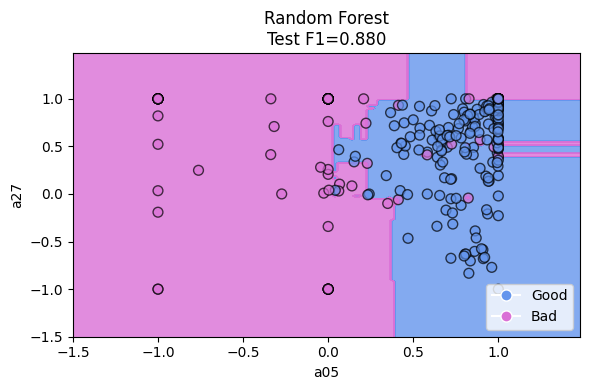


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.8592 (+/- 0.0374)
   >> Metriche test: {'Accuracy': 0.915, 'Precision': 0.88, 'Recall': 0.88, 'F1': 0.88}


In [62]:
results_rfe = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_rfe,
    X_test_2d=X_test_rfe,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_rfe,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

Anche l'algoritmo RFE ha selezionato le stesse feature (a05 e a27), confermando il risultato precedente. Di conseguenza, otteniamo un grafico identico, caratterizzato dalla stessa ottima separazione tra le classi.

### 4. Mutual Information

In [63]:
# Calcola mutual information
mi_scores = mutual_info_classif(X_train, y_train, random_state=RANDOM_STATE)

# Seleziona top 2 features
mi_indices = np.argsort(mi_scores)[::-1][:2]

print(f"\nTop 2 features per MI: {[feature_column_names[i] for i in mi_indices]}")

# Seleziona le features
X_train_mi = X_train[:, mi_indices]
X_test_mi = X_test[:, mi_indices]
feature_names_mi = [feature_column_names[i] for i in mi_indices]


Top 2 features per MI: ['a06', 'a05']


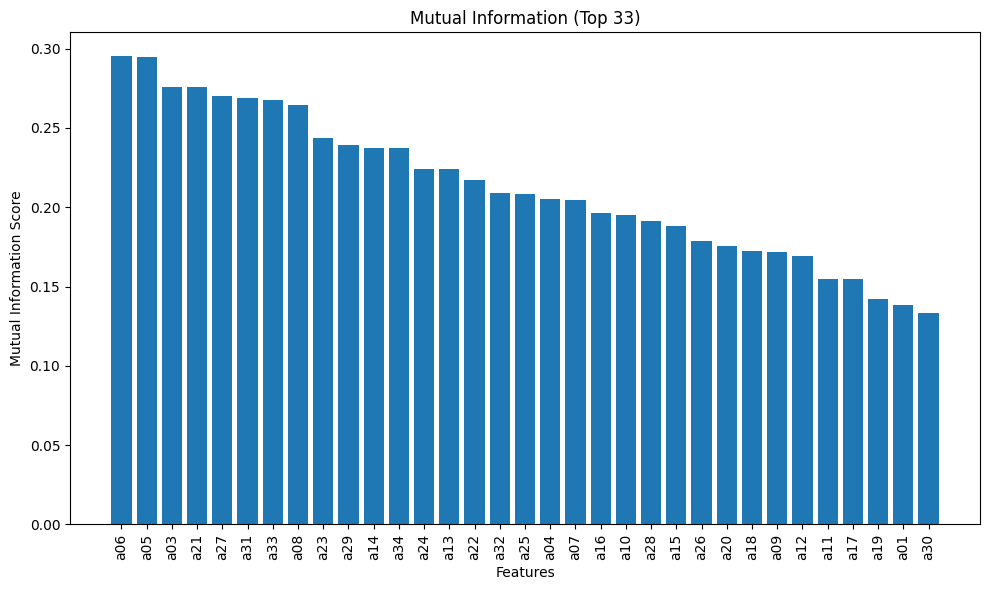

In [64]:
# Visualizza mutual information 
top_n = min(34, len(mi_scores))
plt.figure(figsize=(10, 6))
mi_sorted_indices = np.argsort(mi_scores)[::-1][:top_n]
plt.bar(range(top_n), mi_scores[mi_sorted_indices])
plt.xticks(range(top_n), [feature_column_names[i] for i in mi_sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title(f'Mutual Information (Top {top_n})')
plt.tight_layout()
plt.show()

Questo grafico offre una visione più bilanciata rispetto al Random Forest. Invece di una singola feature dominante, qui l'importanza è distribuita in modo molto più uniforme tra le variabili.

Si ritrovano a05 e a27 ai vertici, a conferma della loro solidità, ma spicca l'ascesa di a06 (ora al primo posto) e a21. Questa differenza nasce dal metodo: mentre il Random Forest tende a scartare le feature che portano informazioni ridondanti, la Mutual Information valuta ogni variabile singolarmente, dando credito anche a quelle che il modello precedente aveva messo in secondo piano.

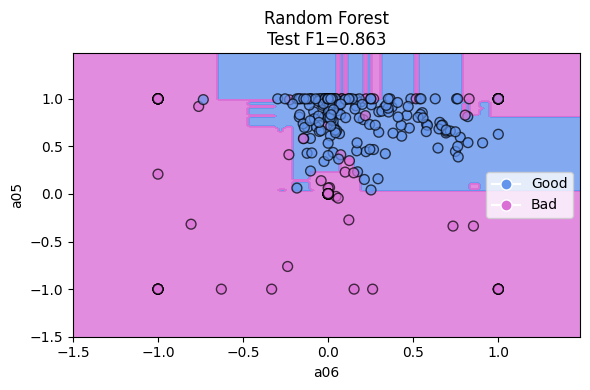


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.8307 (+/- 0.0335)
   >> Metriche test: {'Accuracy': 0.901, 'Precision': 0.846, 'Recall': 0.88, 'F1': 0.863}


In [65]:
results_mi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_mi,
    X_test_2d=X_test_mi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_mi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

Utilizzando le due variabili suggerite dalla Mutual Information (a06 e a05), otteniamo un risultato molto solido: l'F1-Score è 0.863.

Il confronto con il grafico precedente è interessante: sebbene il punteggio sia inferiore rispetto alla coppia scelta dalla feature importance del Random Forest ed il RFE (che arrivava a 0.880 con la a27), sono comunque confrontabili. Questo dimostra che, mentre la feature a05 è insostituibile, cambiare la seconda (usando la a06 al posto della a27) altera di poco il risultato finale: la capacità di separare i segnali buoni da quelli cattivi rimane intatta.

In [66]:
# Crea DataFrame di confronto
df_compare = pd.DataFrame({
    "Original": df_results["F1"][best_model_name],
    "PCA": results_pca[best_model_name]["metrics"]["F1"],
    "Feature Importance": results_fi[best_model_name]["metrics"]["F1"],
    "RFE": results_rfe[best_model_name]["metrics"]["F1"],
    "Mutual Information": results_mi[best_model_name]["metrics"]["F1"],
}, index=["F1"])

print(f"\nConfronto metodi di Feature Selection per {best_model_name}:")
df_compare


Confronto metodi di Feature Selection per Random Forest:


,Original,PCA,Feature Importance,RFE,Mutual Information
F1,0.936,0.68,0.88,0.88,0.863


<Figure size 1000x600 with 0 Axes>

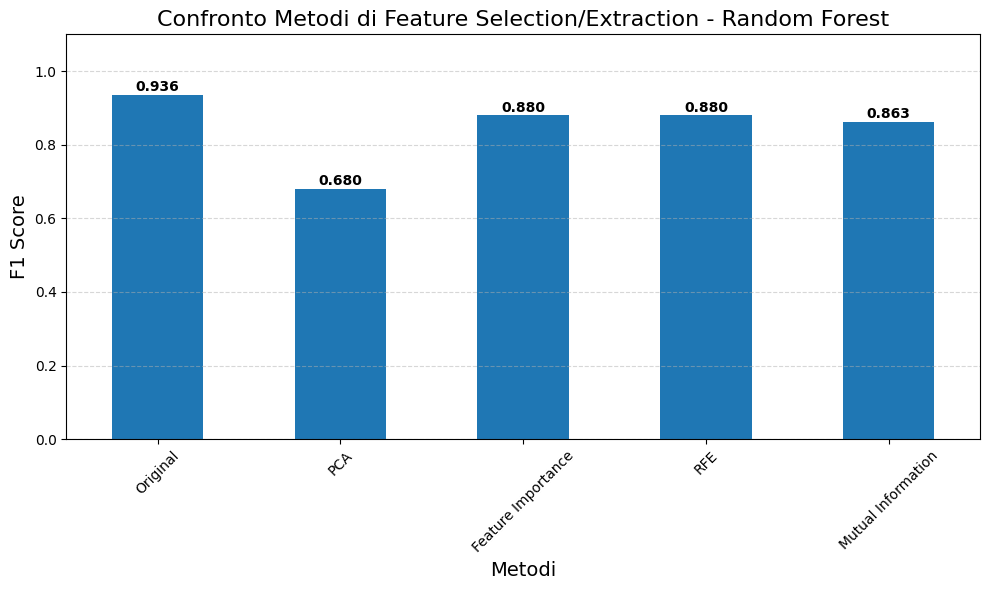

In [67]:
# Visualizza confronto
plt.figure(figsize=(10, 6))
df_compare.T.plot(kind='bar', figsize=(10,6), legend=False)
plt.title(f"Confronto Metodi di Feature Selection/Extraction - {best_model_name}", fontsize=16)
plt.ylabel("F1 Score", fontsize=14)
plt.xlabel("Metodi", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Aggiungi valori sopra le barre
ax = plt.gca()
for i, v in enumerate(df_compare.values[0]):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Il grafico riassume l'esito dell'intera analisi.

Il dato più evidente è la netta superiorità della Feature Selection rispetto alla Feature Extraction. Mentre la PCA ha causato una perdita significativa di performance (crollando a 0.680), i metodi di selezione (Feature Importance e RFE) hanno permesso di mantenere risultati eccellenti (0.880), molto vicini al modello completo.

In conclusione, sebbene l'utilizzo di tutte le 33 feature rimanga necessario per raggiungere la massima precisione (0.936), si è dimostrato che bastano appena due variabili ben scelte (come a05 e a27) per costruire un classificatore solido ed efficiente, evitando la complessità e la perdita di interpretabilità introdotte dalla PCA.